# Base Tumor Growth Inhibition Models

Basic simulations of the TGI model, in different parameter regimes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from treatment_sequencing import GrowthInhibitionModel


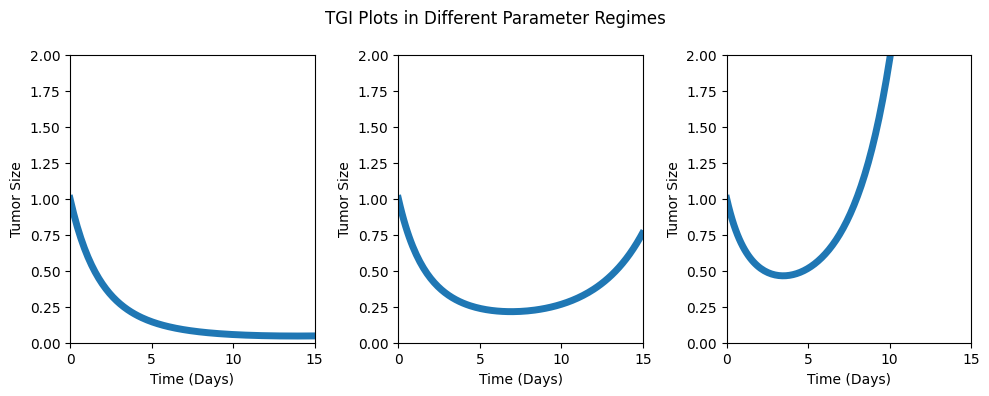

In [2]:
V0 = 1; gamma0 = 1; t_max = 15
lambda_vals = [0.5, 0.5, 0.5]
epsilon_vals = [0.05, 0.1, 0.2]

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for i, ax in enumerate(axs):
    params = {'lambda': lambda_vals[i], 'epsilon': epsilon_vals[i], 'V0': V0, 'gamma0': gamma0}
    model = GrowthInhibitionModel(params=params, method='Radau', dt = 0.11)
    model.simulate(tmax=t_max)
    model.plot(ax=ax)
    ax.set_ylim([0, 2]); ax.set_xlim(0, t_max)
    
plt.suptitle("TGI Plots in Different Parameter Regimes"); plt.tight_layout()